### Importing Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
print(tf.__version__)

2.2.0


### Creating Main dataset

In [2]:
#Read the train.csv file from the right location
training_data = pd.read_csv("training_labels.csv")
#Appending the file extension to the image names
training_imgs = ["{}.jpg".format(x) for x in list(training_data.Image_name)]

#Creating a new dataframe with updated images names
training_labels_1 = list(training_data['Retinopathy_grade'])
training_data = pd.DataFrame( {'Images': training_imgs,'Retinopathy_grade': training_labels_1})


Creating seperate column for Binary Classification

In [3]:
binary_grade=[]

In [4]:
for i in range(len(training_data)):
    if training_data.Retinopathy_grade[i]>0:
        #for DR images
        binary_grade.append(1)
    else:
        #for non-DR images
        binary_grade.append(0)

In [6]:
se = pd.Series(binary_grade)
training_data['binary_grade'] = se.values

In [5]:
#Changing the type of categorical variable for datagenerator(from int to str)
training_data.Retinopathy_grade = training_data.Retinopathy_grade.astype(str)

In [7]:
#Changing the type of categorical variable datagenerator(from int to str)
training_data.binary_grade = training_data.binary_grade.astype(str)

In [8]:
#Checking if binary label is correct
print(training_data.Retinopathy_grade[137], training_data.binary_grade[137])

0 0


In [9]:
""""
img=cv2.imread('D:\Personal\Practice\BE project\DR classification\Images\Training Set\IDRiD_001.jpg')
resized=cv2.resize(img, (600,600))
plt.show(plt.imshow(img,cmap='gray'))
plt.show(plt.imshow(resized,cmap='gray'))
"""

'"\nimg=cv2.imread(\'D:\\Personal\\Practice\\BE project\\DR classification\\Images\\Training Set\\IDRiD_001.jpg\')\nresized=cv2.resize(img, (600,600))\nplt.show(plt.imshow(img,cmap=\'gray\'))\nplt.show(plt.imshow(resized,cmap=\'gray\'))\n'

In [9]:
training_data.head()

,Images,Retinopathy_grade,binary_grade
0,IDRiD_001.jpg,3,1
1,IDRiD_002.jpg,3,1
2,IDRiD_003.jpg,2,1
3,IDRiD_004.jpg,3,1
4,IDRiD_005.jpg,4,1


### Splitting the dataset into train and validation

In [10]:
from sklearn.model_selection import train_test_split
training_set, validation_set = train_test_split(training_data, random_state = 0, test_size = 0.10)

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
train_dataGen = ImageDataGenerator(rescale = 1./255,
                                      shear_range = 0.2,
                                      zoom_range = 0.2,
                                      horizontal_flip = True)

In [13]:
validation_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
TARGET_SIZE=(600,600)

In [25]:
train_generator = train_dataGen.flow_from_dataframe(dataframe = training_set, directory="BE project/DR classification/Images/Training Set/",x_col="Images", y_col="binary_grade", class_mode="binary", target_size=TARGET_SIZE, batch_size=4)

Found 371 validated image filenames belonging to 2 classes.


In [26]:
validation_generator = validation_datagen.flow_from_dataframe(dataframe= validation_set, directory="BE project/DR classification/Images/Training Set/", x_col="Images", y_col="binary_grade", class_mode="binary", target_size=TARGET_SIZE, batch_size=4)

Found 42 validated image filenames belonging to 2 classes.


In [17]:
IMG_SHAPE = (600, 600, 3)

In [18]:
#Create the base model from the pre-trained model EfficientNetB7 
import efficientnet.tfkeras as efc
base_model = efc.EfficientNetB7(input_shape=IMG_SHAPE,
                include_top=False,
                weights='imagenet')

In [19]:
base_model.trainable = False

In [27]:
model = tf.keras.Sequential([
                          base_model,
                          keras.layers.GlobalAveragePooling2D(),
                          keras.layers.Dense(1, activation='sigmoid')])

In [36]:
#Optimizer Adam>SGD(not completely tested)>RMSprop
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [37]:
epochs = 40
steps_per_epoch = 70
validation_steps = 70

In [38]:
#can use model.fit as well
history = model.fit_generator(train_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs=epochs,
                              workers=4,
                              validation_data=validation_generator,
                              validation_steps=validation_steps)

Epoch 1/40
70/70 [==============================] - 104s 1s/step - loss: 0.5558 - binary_accuracy: 0.7061 - val_loss: 0.5472 - val_binary_accuracy: 0.7313
Epoch 2/40
70/70 [==============================] - 98s 1s/step - loss: 0.4800 - binary_accuracy: 0.7464 - val_loss: 0.5401 - val_binary_accuracy: 0.6381
Epoch 3/40
70/70 [==============================] - 95s 1s/step - loss: 0.4657 - binary_accuracy: 0.7563 - val_loss: 0.5058 - val_binary_accuracy: 0.7201
Epoch 4/40
70/70 [==============================] - 98s 1s/step - loss: 0.4417 - binary_accuracy: 0.7599 - val_loss: 0.4686 - val_binary_accuracy: 0.7910
Epoch 5/40
70/70 [==============================] - 96s 1s/step - loss: 0.4270 - binary_accuracy: 0.7921 - val_loss: 0.4529 - val_binary_accuracy: 0.7388
Epoch 6/40
70/70 [==============================] - 99s 1s/step - loss: 0.3996 - binary_accuracy: 0.8143 - val_loss: 0.4362 - val_binary_accuracy: 0.7612
Epoch 7/40
70/70 [==============================] - 101s 1s/step - loss: 0.

In [39]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

In [40]:
loss = history.history['loss']
val_loss = history.history['val_loss']

### Plotting Accuracy and Loss

Text(0.5, 1.0, 'Training and Validation Accuracy')

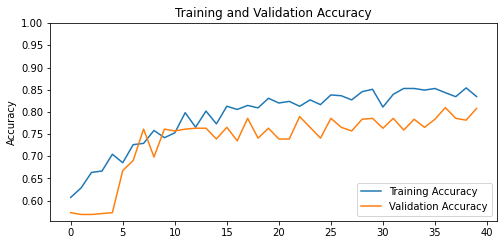

In [28]:
#Training Set
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

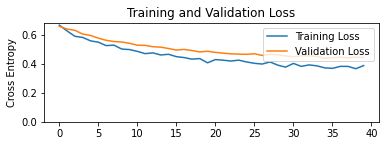

In [29]:
#Validation Set
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [41]:
#saving model
model.save('D:\\Personal\\Practice\\BE project')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: D:\Personal\Practice\BE project\assets


In [ ]:
#loading weights and biases of pretrained model
from tensorflow import keras
model = keras.models.load_model('D:\\Personal\\Practice\\BE project')

In [42]:
#Function to scale and resize test image
def predict_image(image):
    scaled_image=image.astype('float32')
    scaled_image /= 255 
    #Resizing the image
    resized_image = cv2.resize(scaled_image, (600,600))
    """
    #Normalization for each pixel
    print('The prediction-ready image:')
    plt.show(plt.imshow(resized_image, cmap='gray'))
    """
    #predicting the digit
    prediction = model.predict(resized_image.reshape(1,resized_image.shape[0],resized_image.shape[1],3))
    if prediction[0][0]>0.5:
        return 1
    else:
        return 0

In [87]:
image=cv2.imread("BE project/DR classification/Images/Testing Set/IDRiD_004.jpg")

In [88]:
#Testing a single image
y=predict_image(image)
print(y)

1


In [93]:
import os
from keras.preprocessing import image
folder_path="BE project/DR classification/Images/Testing Set/"

In [108]:
predict_list=[]

In [109]:
#Testing entire directory
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg"):
        data=cv2.imread("BE project/DR classification/Images/Testing Set/"+filename)
        y=predict_image(data)
        predict_list.append(y)
        continue
    else:
        continue

In [119]:
seriess = pd.Series(predict_list)
testing_data['prediction'] = seriess.values

In [120]:
testing_data

,Images,Retinopathy_grade,test_grade,prediction
0,IDRiD_001.jpg,4,1,1
1,IDRiD_002.jpg,4,1,1
2,IDRiD_003.jpg,4,1,1
3,IDRiD_004.jpg,4,1,1
4,IDRiD_005.jpg,4,1,1
...,...,...,...,...
98,IDRiD_099.jpg,0,0,0
99,IDRiD_100.jpg,2,1,1
100,IDRiD_101.jpg,1,1,1
101,IDRiD_102.jpg,2,1,1


In [127]:
y_true=testing_data['test_grade']
y_pred=testing_data['prediction']

In [122]:
from sklearn.metrics import recall_score, accuracy_score, precision_score,f1_score

In [125]:
#Changing the type of categorical variable(from int to str)
testing_data.test_grade = testing_data.test_grade.astype(int)
testing_data.prediction = testing_data.prediction.astype(int)

In [129]:
recall=recall_score(y_true,y_pred)
precision=precision_score(y_true,y_pred)
accuracy=accuracy_score(y_true,y_pred)
f1=f1_score(y_true,y_pred)

In [130]:
print("Recall score:",recall, "Precision score:",precision, "Accuracy score:",accuracy, "F1 score:",f1)

Recall score: 0.8840579710144928 Precision score: 0.7349397590361446 Accuracy score: 0.7087378640776699 F1 score: 0.8026315789473685
